# Kernel is prepared for assignment of Pucho Technology**

In [1]:
import numpy as np
import pandas as pd
import nltk
import random
import os
from os import path
from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec

In [2]:
df = pd.read_csv("Cloth_reviews.csv")
df.drop(df.columns[0],inplace=True, axis=1)

#check null values
print("Missing Values: {}".format(df.isnull().sum().sum()))
df.head()

Missing Values: 4697


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
# Delete missing observations for following variables
for x in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[x].notnull()]

# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in df.columns:
    unique_count.append([x,len(df[x].unique()),df[x].isnull().sum()])

# Missing Values
print("Missing Values: {}".format(df.isnull().sum().sum()))
print("Dataframe Dimension:")
print(df.shape)

df["Word Count"] = df['Review Text'].str.split().apply(len)
df["Character Count"] = df['Review Text'].apply(len)
df["Label"] = 0
df.loc[df.Rating >= 3,["Label"]] = 1

Missing Values: 2966
Dataframe Dimension:
(22628, 10)


In [4]:
df.sample(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Character Count,Label
15754,1078,35,"Flattering, size up",I am petite with somewhat broad shoulders. ius...,4,1,0,General,Dresses,Dresses,74,389,1
1153,1060,55,Absolutely beautiful and feminine,This is not something i would normal wear but ...,5,1,34,General,Bottoms,Pants,73,355,1
23133,1079,58,Love this dress,I was returning an in line order from same des...,5,1,5,General Petite,Dresses,Dresses,28,138,1


## Univariate Distribution

In [5]:
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))
pd.DataFrame(unique_count, columns=["Column","Unique","Missing"]).set_index("Column").T

Dataframe Dimension: 22628 Rows, 13 Columns


Column,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
Unique,1172,77,13984,22621,5,2,82,3,6,20
Missing,0,0,2966,0,0,0,0,0,0,0


In [6]:
df.describe().T.drop("count",axis=1)

,mean,std,min,25%,50%,75%,max
Clothing ID,919.695908,201.683804,1.0,861.0,936.0,1078.0,1205.0
Age,43.282880,12.328176,18.0,34.0,41.0,52.0,99.0
Rating,4.183092,1.115911,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.818764,0.385222,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.631784,5.787520,0.0,0.0,1.0,3.0,122.0
Word Count,60.211950,28.533053,2.0,36.0,59.0,88.0,115.0
Character Count,308.761534,143.934126,9.0,186.0,302.0,459.0,508.0
Label,0.895263,0.306222,0.0,1.0,1.0,1.0,1.0


**Age and Positive Feedback Count Distributions:**

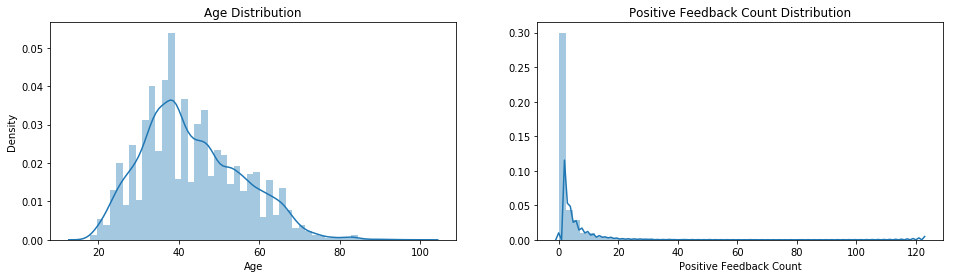

In [7]:
# Continous Distributions
f, ax = plt.subplots(1,2,figsize=(16,4), sharey=False)

#age distribution
sns.distplot(df.Age, ax=ax[0])
ax[0].set_title("Age Distribution")
ax[0].set_ylabel("Density")

#pos feedback count
sns.distplot(df["Positive Feedback Count"], ax=ax[1])
ax[1].set_title("Positive Feedback Count Distribution")

plt.show()

**Categories count**

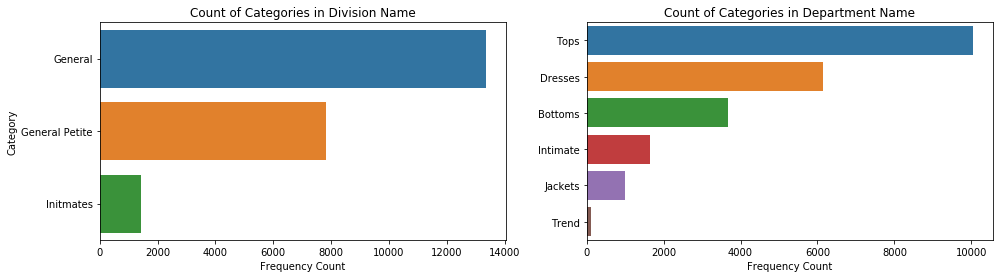

In [8]:
row_plots = ["Division Name","Department Name"]
f, axes = plt.subplots(1,len(row_plots), figsize=(16,4), sharex=False)

for i,x in enumerate(row_plots):
    sns.countplot(y=x, data=df,order=df[x].value_counts().index, ax=axes[i])
    axes[i].set_title("Count of Categories in {}".format(x))
    axes[i].set_xlabel("")
    axes[i].set_xlabel("Frequency Count")
axes[0].set_ylabel("Category")
axes[1].set_ylabel("")
plt.show()

**Distribution of Clothing ID to Understand Product Popularity**

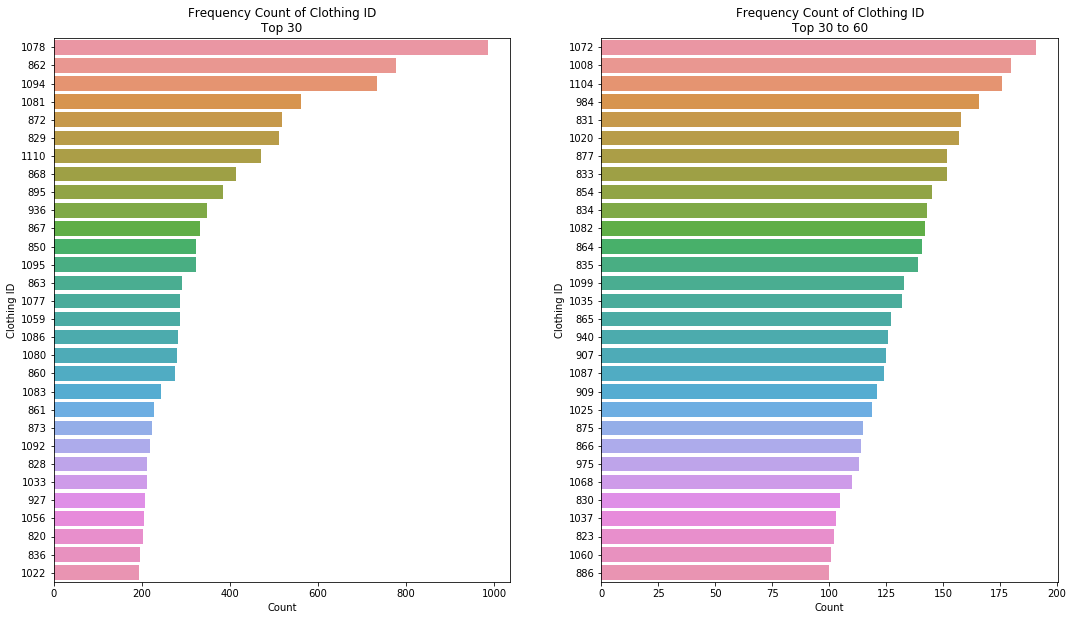

In [9]:
# Clothing ID Category
f, axes = plt.subplots(1,2, figsize=[18,10])
num = 30
sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[:num].index)],
              order= df["Clothing ID"].value_counts()[:num].index, ax=axes[0])
axes[0].set_title("Frequency Count of Clothing ID\nTop 30")
axes[0].set_xlabel("Count")

sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[num:60].index)],
              order= df["Clothing ID"].value_counts()[num:60].index, ax=axes[1])
axes[1].set_title("Frequency Count of Clothing ID\nTop 30 to 60")
axes[1].set_xlabel("Count")
plt.show()

**Frequency count by class name**

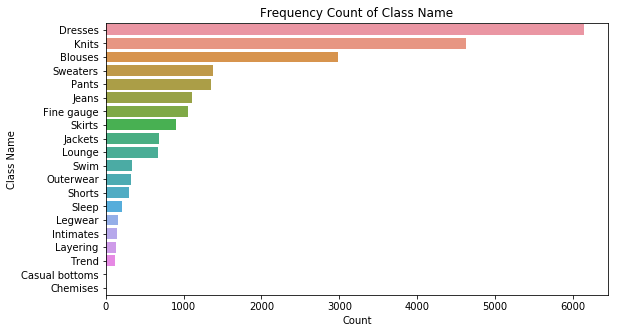

In [10]:
# Class Name
plt.subplots(figsize=(9,5))
sns.countplot(y="Class Name", data=df,order=df["Class Name"].value_counts().index)

plt.title("Frequency Count of Class Name")
plt.xlabel("Count")
plt.show()

**Distribution of Rating, Recommended IND, and Label**

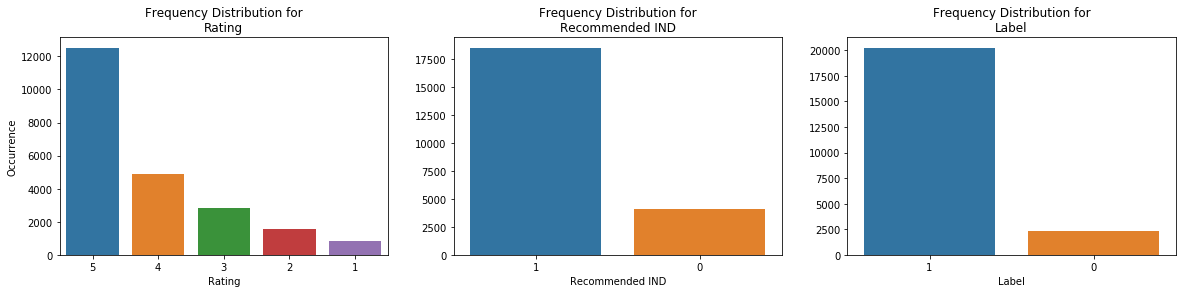

In [11]:
cat_dtypes = ["Rating","Recommended IND","Label"]
increment = 0
f, axes = plt.subplots(1,len(cat_dtypes), figsize=(20,4), sharex=False)

for i in range(len(cat_dtypes)):
    sns.countplot(x=cat_dtypes[increment], data=df,order=df[cat_dtypes[increment]].value_counts().index, ax=axes[i])
    axes[i].set_title("Frequency Distribution for\n{}".format(cat_dtypes[increment]))
    axes[i].set_ylabel("Occurrence")
    axes[i].set_xlabel("{}".format(cat_dtypes[increment]))
    increment += 1
axes[1].set_ylabel("")
axes[2].set_ylabel("")
plt.show()

**Word and Length:**


In [12]:
##I don't know much about kde plots since i explore them first time so i took the reference from other kaggle kernel

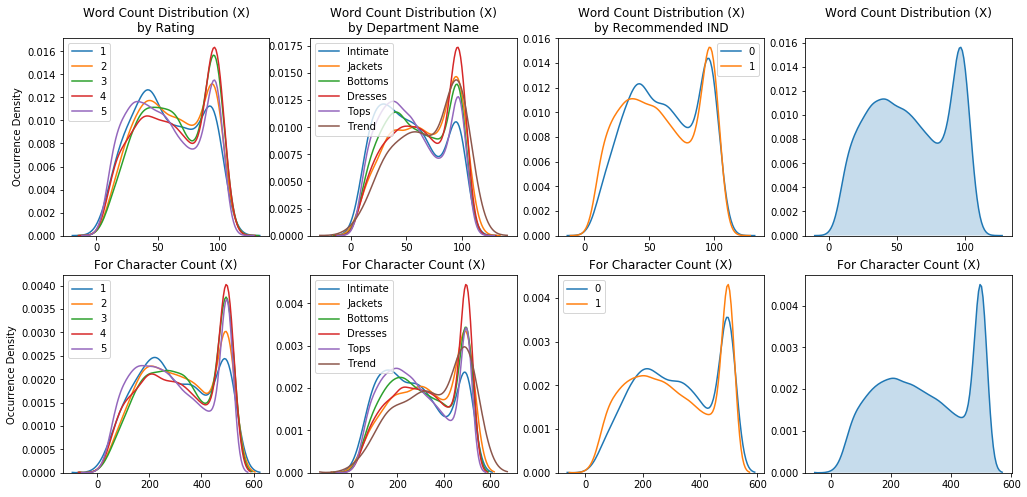

Correlation Coefficient of Word Cound and Character Count: 0.99

Total Word Count is: 1362476
Total Character Count is: 6986656


In [13]:
f, axes = plt.subplots(2,4, figsize=(17,8), sharex=False)
for ii, xvar in enumerate(['Word Count', "Character Count"]):
    for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
        for x in set(df[y][df[y].notnull()]):
            sns.kdeplot(df[xvar][df[y]==x], label=x, shade=False, ax=axes[ii,i])
        if ii is 0:
            axes[ii,i].set_title('{} Distribution (X)\nby {}'.format(xvar, y))
        else:
            axes[ii,i].set_title('For {} (X)'.format(xvar))
    axes[ii,0].set_ylabel('Occurrence Density')
    axes[ii,i].set_xlabel('')
    # Plot 4
    sns.kdeplot(df[xvar],shade=True,ax=axes[ii,3])
    axes[ii,3].set_xlabel("")
    if ii is 0:
        axes[ii,3].set_title('{} Distribution (X)\n'.format(xvar))
    else:
        axes[ii,3].set_title('For {} (X)'.format(xvar))
    axes[ii,3].legend_.remove()
plt.show()

print("Correlation Coefficient of Word Cound and Character Count: {}".format(
    round(df["Word Count"].corr(df["Character Count"]), 2)))

print("\nTotal Word Count is: {}".format(df["Word Count"].sum()))
print("Total Character Count is: {}".format(df["Character Count"].sum()))

## Multivariate Distribution

**Division Name by Department Name:**

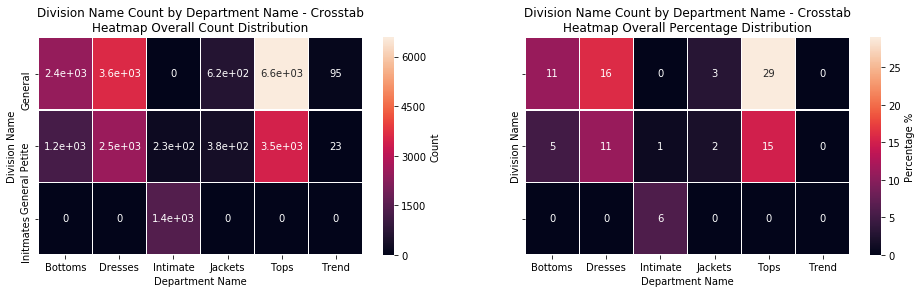

In [14]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"]),annot=True, linewidths=.5, ax = ax[0],
            cbar_kws={'label': 'Count'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize=True).mul(100).round(0),annot=True, linewidths=.5, ax=ax[1],
            cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')

plt.show()

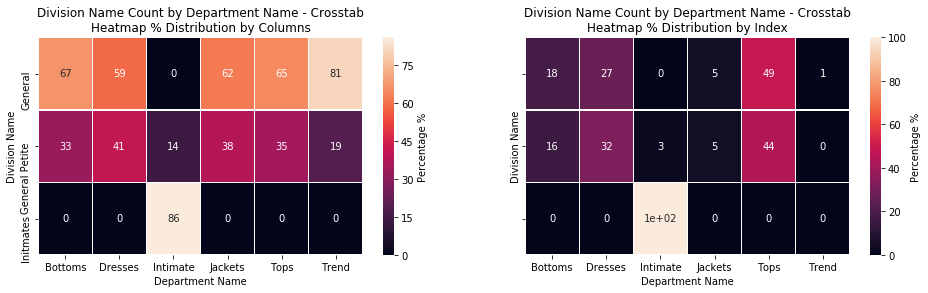

In [15]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize='columns').mul(100).round(0),annot=True, linewidths=.5, ax=ax[0],
            cbar_kws={'label': 'Percentage %'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Columns')

sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize='index').mul(100).round(0),annot=True, linewidths=.5, ax=ax[1],
            cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Index')

plt.show()

### Continuous Variable by Categorical Variable

**Positive Feedback Count Distribution by Rating, Department Name, Recommended IND, and Class Name**

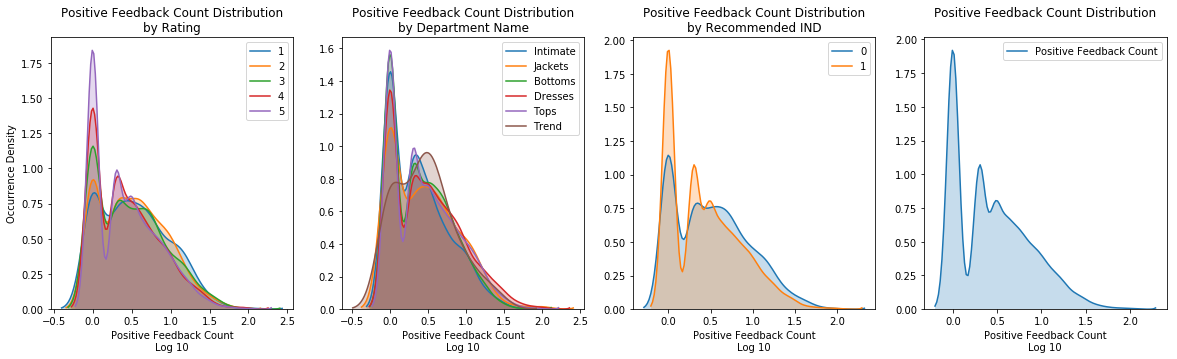

In [16]:
np.seterr(divide = 'ignore') 
f, axes = plt.subplots(1,4, figsize=(20,5), sharex=False)

xvar = 'Positive Feedback Count'
plotdf = np.log10(df['Positive Feedback Count'])
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=True, ax=axes[i])
    axes[i].set_xlabel("{}\nLog 10".format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution\nby {}'.format(xvar, y))
axes[0].set_ylabel('Occurrence Density')

sns.kdeplot(plotdf,shade=True,ax=axes[3])
axes[3].set_xlabel("{}\nLog 10".format(xvar))
axes[3].set_title('{} Distribution\n'.format(xvar))
plt.show()

**Age Distribution by the Usual Suspects.. round them up**

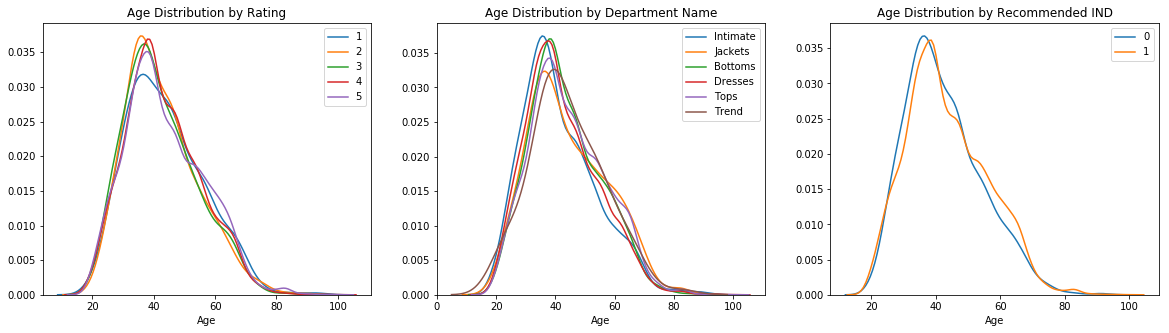

In [17]:
f, axes = plt.subplots(1,3, figsize=(20,5), sharex=False)

xvar = "Age"
plotdf = df["Age"]
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=False, ax=axes[i])
    axes[i].set_xlabel("{}".format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution by {}'.format(xvar, y))

### Continuous Variables  on Continuous Variables

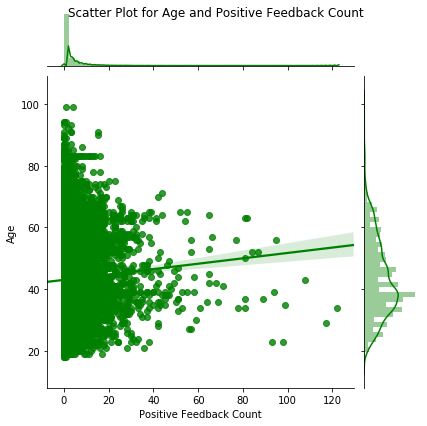

In [18]:
def minmaxscaler(df):
    return (df-df.min())/(df.max()-df.min())
def zscorenomalize(df):
    return (df - df.mean())/df.std()

g = sns.jointplot(x= df["Positive Feedback Count"], y=df["Age"], kind='reg', color='g')
g.fig.suptitle("Scatter Plot for Age and Positive Feedback Count")
plt.show()

In [19]:
def percentstandardize_barplot(x,y,hue, data, ax=None, order= None):
    """
    Standardize by percentage the data using pandas functions, then plot using Seaborn.
    Function arguments are and extention of Seaborns'.
    """
    sns.barplot(x= x, y=y, hue=hue, ax=ax, order=order,
    data=(data[[x, hue]]
     .reset_index(drop=True)
     .groupby([x])[hue]
     .value_counts(normalize=True)
     .rename('Percentage').mul(100)
     .reset_index()
     .sort_values(hue)))
    
    plt.title("Percentage Frequency of {} by {}".format(hue,x))
    plt.ylabel("Percentage %")

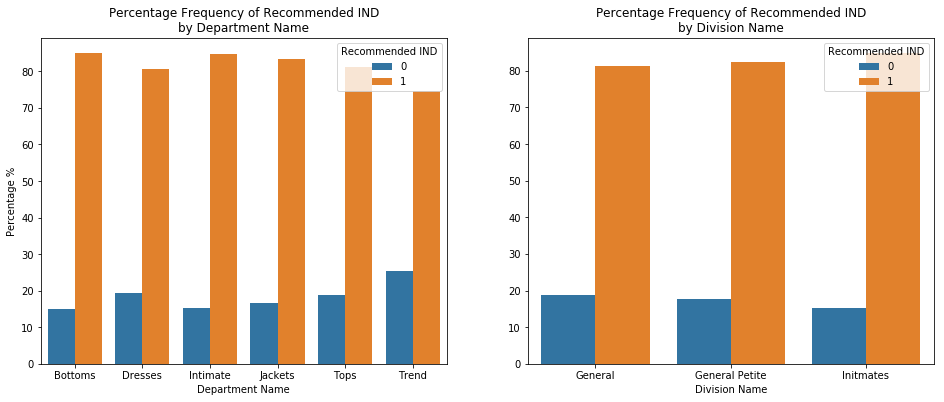

In [20]:
huevar = "Recommended IND"
f, axes = plt.subplots(1,2,figsize=(16,6))
percentstandardize_barplot(x="Department Name",y="Percentage", hue=huevar,data=df, ax=axes[0])
axes[0].set_title("Percentage Frequency of {}\nby Department Name".format(huevar))
axes[0].set_ylabel("Percentage %")
percentstandardize_barplot(x="Division Name",y="Percentage", hue=huevar,data=df, ax=axes[1])
axes[1].set_title("Percentage Frequency of {}\nby Division Name".format(huevar))
axes[1].set_ylabel("")
plt.show()

**Rating by Department and Divison Name**

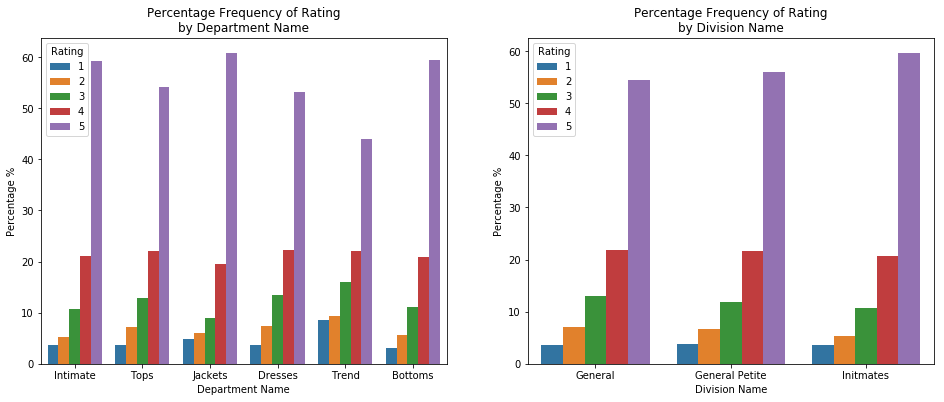

In [21]:
xvar = ["Department Name","Division Name"]
huevar = "Rating"
f, axes = plt.subplots(1,2,figsize=(16,6))
percentstandardize_barplot(x=xvar[0],y="Percentage", hue=huevar,data=df, ax=axes[0])
axes[0].set_title("Percentage Frequency of {}\nby {}".format(huevar, xvar[0]))
axes[0].set_ylabel("Percentage %")
percentstandardize_barplot(x=xvar[1],y="Percentage", hue="Rating",data=df, ax=axes[1])
axes[1].set_title("Percentage Frequency of {}\nby {}".format(huevar, xvar[1]))
plt.show()


**Rating by Recommended IND**


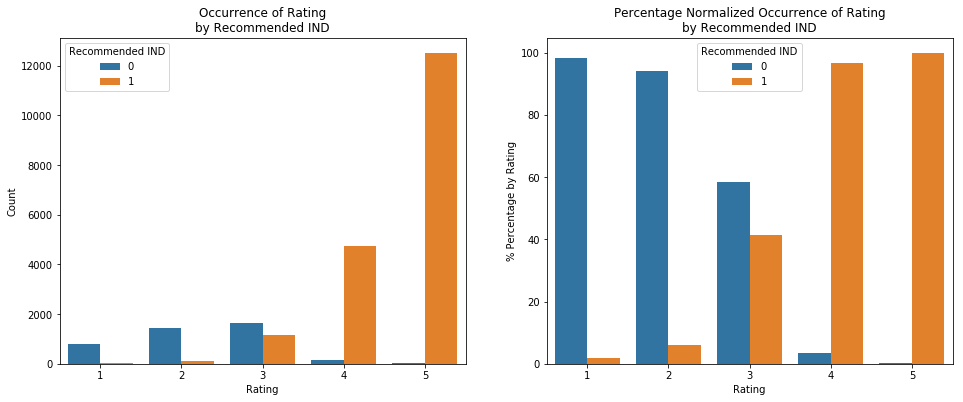

In [22]:
huevar = "Rating"
f, axes = plt.subplots(1,2,figsize=(16,6))
sns.countplot(x="Rating", hue="Recommended IND",data=df, ax=axes[0])
axes[0].set_title("Occurrence of {}\nby {}".format(huevar, "Recommended IND"))
axes[0].set_ylabel("Count")
percentstandardize_barplot(x="Rating",y="Percentage", hue="Recommended IND",data=df, ax=axes[1])
axes[1].set_title("Percentage Normalized Occurrence of {}\nby {}".format(huevar, "Recommended IND"))
axes[1].set_ylabel("% Percentage by Rating")
plt.show()

## Multivariate Analysis and Descriptive Statistics

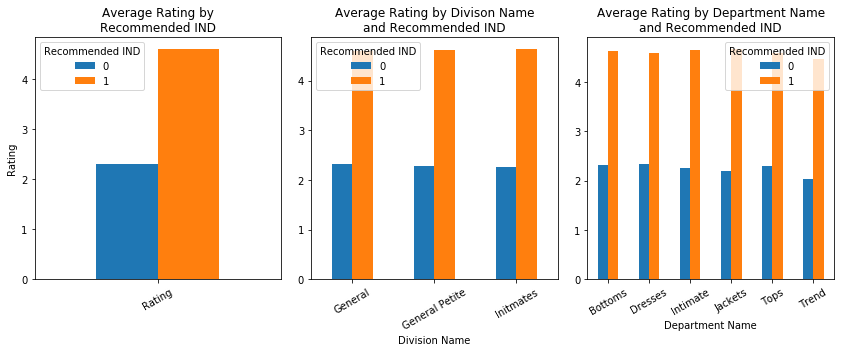

In [23]:
f, axes = plt.subplots(1,3,figsize=(12,5))
rot = 30
df.pivot_table('Rating',
               columns=['Recommended IND']).plot.bar(ax=axes[0],rot=rot)
axes[0].set_title("Average Rating by\nRecommended IND")
df.pivot_table('Rating', index='Division Name',
               columns=['Recommended IND']).plot.bar(ax=axes[1], rot=rot)
axes[1].set_title("Average Rating by Divison Name\nand Recommended IND")
df.pivot_table('Rating', index='Department Name',
               columns=['Recommended IND']).plot.bar(ax=axes[2], rot=rot)
axes[0].set_ylabel("Rating")
axes[2].set_title("Average Rating by Department Name\nand Recommended IND")
f.tight_layout()
plt.show()

## Working with Text

### Text Pe-Processing

In [24]:
pd.set_option('max_colwidth', 500)
df[["Title","Review Text", "Rating"]].sample(7)

,Title,Review Text,Rating
3907,Great dress,I have this in black and red. it's a great and flattering dress that is a worn a bit large. you can wear it out on a date or more casual. the fabric is super comfortable as well.,4
7702,Just as expected,"Had been eyeing this for a while. print is beautiful in person, just as pictured. tts fit (size 8, 5'7"", 150#, pear shaped). comes within a couple inches of my knees so long enough to wear to work.",5
5005,NaN,"What a let down. the sweater i received in no way resembles the product pictured. based on the original price point, i envisioned a beautiful hand-knitted sweater made of high grade yarn/ wool that i could use for travel. instead, i received something that is grossly oversized for xs/s, made out of weird crafting yarn and looks like an ugly holiday sweater. my kids could make something better than this on their toy loom. not the quality i expected from retailer. back it goes.",1
2880,NaN,Nice top that can be worn alone or underneath a sweater. can be dressed up or down and worn in all seasons.,5
17155,So flattering,"This dress fits beautifully. the fabric is thick enough to feel significant and not flimsy, but the dress doesn't feel heavy at all. the detail is gorgeous, but still subtle. it's a little too nice for me to wear to work, but the perfect special occasion or party dress",5
11880,Well made; but huge,"The fabric is a nice weight knit and the top generally well made. unfortunately, the fit was enormous. i've an athletic build w/ big boobs & normally wear l in retailer tops.",2
5849,Size up,"I typically wear a 26 or 27 in jeans, had to size up to a 28 in these. the legs felt fine in the size 27, but the waistband was a bit tight, so i went with the 28s. i am 5'2"" 115lbs. i'll also be hemming or possibly just cutting these off, they are about 4 inches longer on me compared to the model pictured.",5


Evidently, the text data requires further processing .

In [25]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    #words = [ps.stem(w) for w in words] #4
    return words

### Sentiment Analysis

In [26]:
# Pre-Processing
SIA = SentimentIntensityAnalyzer()
df["Review Text"]= df["Review Text"].astype(str)

# Applying Model, Variable Creation
df['Polarity Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['compound'])
df['Neutral Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neu'])
df['Negative Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neg'])
df['Positive Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['pos'])

# Converting 0 to 1 Decimal Score to a Categorical Variable
df['Sentiment']=''
df.loc[df['Polarity Score']>0,'Sentiment']='Positive'
df.loc[df['Polarity Score']==0,'Sentiment']='Neutral'
df.loc[df['Polarity Score']<0,'Sentiment']='Negative'

**Normalize Plots for Sentiment Distribution**

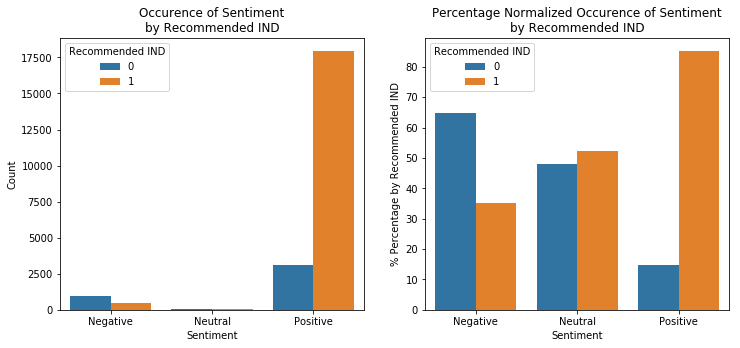

In [27]:
huevar = "Recommended IND"
xvar = "Sentiment"
f, axes = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x=xvar, hue=huevar,data=df, ax=axes[0], order=["Negative","Neutral","Positive"])
axes[0].set_title("Occurence of {}\nby {}".format(xvar, huevar))
axes[0].set_ylabel("Count")
percentstandardize_barplot(x=xvar,y="Percentage", hue=huevar,data=df, ax=axes[1])
axes[1].set_title("Percentage Normalized Occurence of {}\nby {}".format(xvar, huevar))
axes[1].set_ylabel("% Percentage by {}".format(huevar))
plt.show()

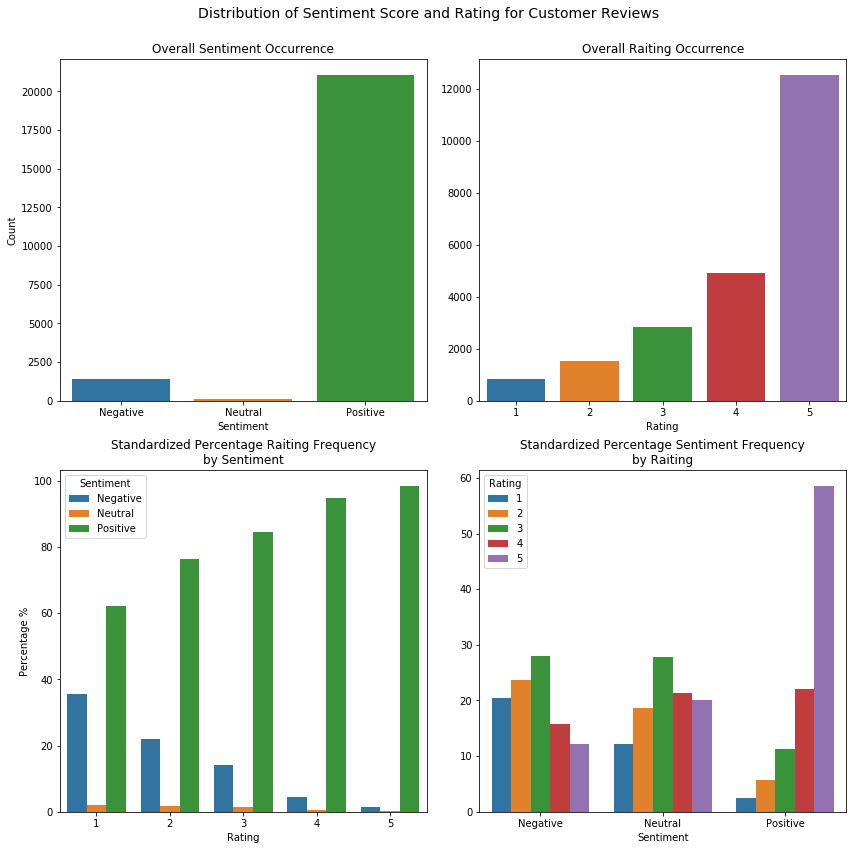

In [28]:
f, axes = plt.subplots(2,2, figsize=[12,12])
sns.countplot(x="Sentiment", data=df, ax=axes[0,0], order=["Negative","Neutral","Positive"])
axes[0,0].set_xlabel("Sentiment")
axes[0,0].set_ylabel("Count")
axes[0,0].set_title("Overall Sentiment Occurrence")

sns.countplot(x="Rating", data=df, ax=axes[0,1])
axes[0,1].set_xlabel("Rating")
axes[0,1].set_ylabel("")
axes[0,1].set_title("Overall Raiting Occurrence")

percentstandardize_barplot(x="Rating",y="Percentage",hue="Sentiment",data=df, ax=axes[1,0])
axes[1,0].set_xlabel("Rating")
axes[1,0].set_ylabel("Percentage %")
axes[1,0].set_title("Standardized Percentage Raiting Frequency\nby Sentiment")

percentstandardize_barplot(x="Sentiment",y="Percentage",hue="Rating",data=df, ax=axes[1,1])
axes[1,1].set_ylabel("Occurrence Frequency")
axes[1,1].set_title("Standardized Percentage Sentiment Frequency\nby Raiting")
axes[1,1].set_xlabel("Sentiment")
axes[1,1].set_ylabel("")

f.suptitle("Distribution of Sentiment Score and Rating for Customer Reviews", fontsize=14)
f.tight_layout()
f.subplots_adjust(top=0.92)
plt.show()

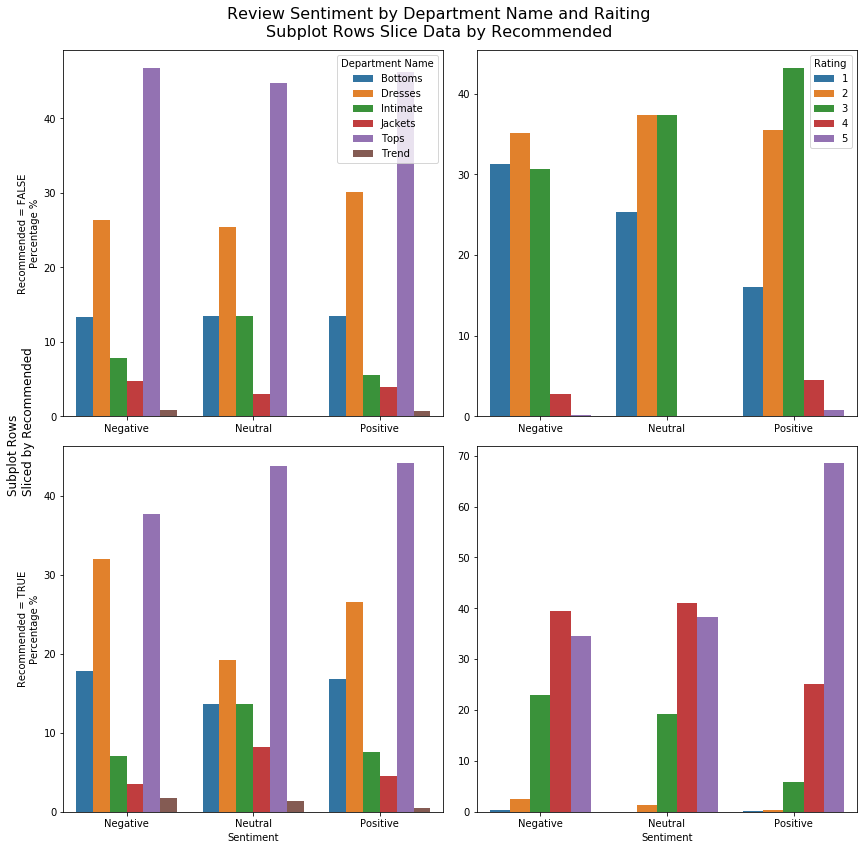

In [29]:
# Tweakable Variables (Note to Change Order Arguement if Xvar is changed)
xvar = "Sentiment"
huevar = "Department Name"
rowvar = "Recommended IND"

# Plot
f, axes = plt.subplots(2,2,figsize=(12,12), sharex=False,sharey=False)
for i,x in enumerate(set(df[rowvar][df[rowvar].notnull()])):
    percentstandardize_barplot(x=xvar,y="Percentage", hue=huevar,data=df[df[rowvar] == x],
                 ax=axes[i,0], order=["Negative","Neutral","Positive"])
    percentstandardize_barplot(x=xvar,y="Percentage", hue="Rating",data=df[df[rowvar] == x],
                 ax=axes[i,1], order=["Negative","Neutral","Positive"])

# Plot Aesthetics
axes[1,0].legend_.remove()
axes[1,1].legend_.remove()
axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[0,0].set_ylabel("Recommended = FALSE\nPercentage %")
axes[1,0].set_ylabel("Recommended = TRUE\nPercentage %")
axes[1,1].set_title("")

# Common title and ylabel
f.text(0.0, 0.5, 'Subplot Rows\nSliced by Recommended', va='center', rotation='vertical', fontsize=12)
f.suptitle("Review Sentiment by Department Name and Raiting\nSubplot Rows Slice Data by Recommended", fontsize=16)
f.tight_layout()
f.subplots_adjust(top=0.93)
plt.show()

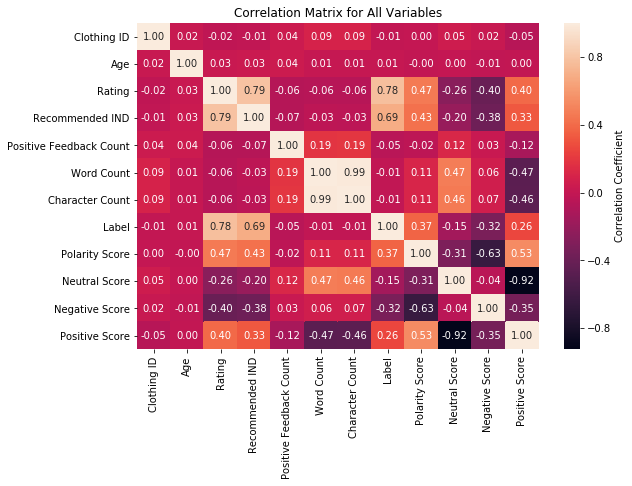

In [30]:
# Plot Correlation Matrix
f, ax = plt.subplots(figsize=[9,6])
ax = sns.heatmap(df.corr(), annot=True,
                 fmt=".2f",cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title("Correlation Matrix for All Variables")
plt.show()

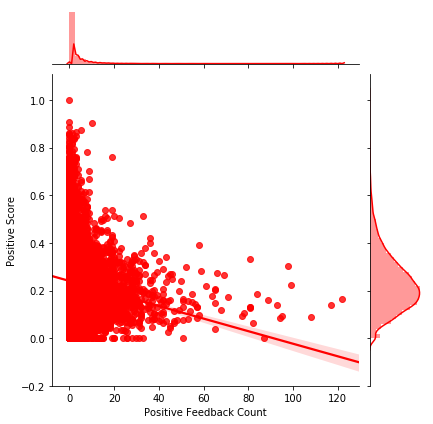

In [31]:
# Sentiment Positivity Score by Positive Feedback Count
ax = sns.jointplot(x= df["Positive Feedback Count"], y=df["Positive Score"], kind='reg', color='r')
plt.show()


## Word Distribution and Word Cloud


In [32]:
stopwords = set(STOPWORDS)
size = (10,7)

def cloud(text, title, stopwords=stopwords, size=size):
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    # Redundant when combined with my Preprocessing function
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(str(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()
    
# Frequency Calculation [One-Gram]
def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)

def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    return rslt

### Visualize Titles

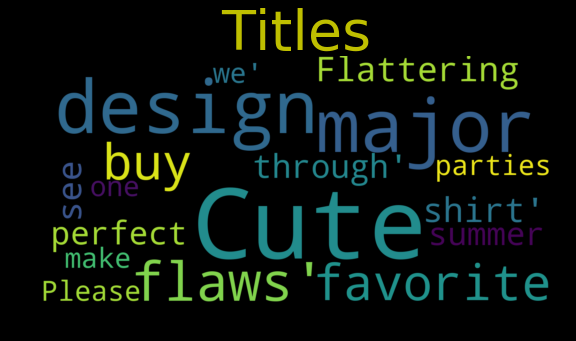

In [33]:
# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite"])

# Cloud
cloud(text= df.Title[df.Title.notnull()].astype(str).values,
      title="Titles",
      stopwords= new_stop,
      size = (7,4))

### Visualize Reviews

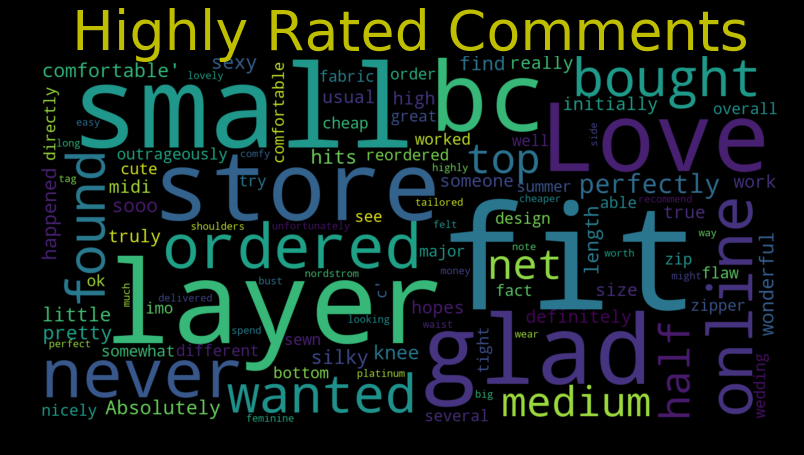

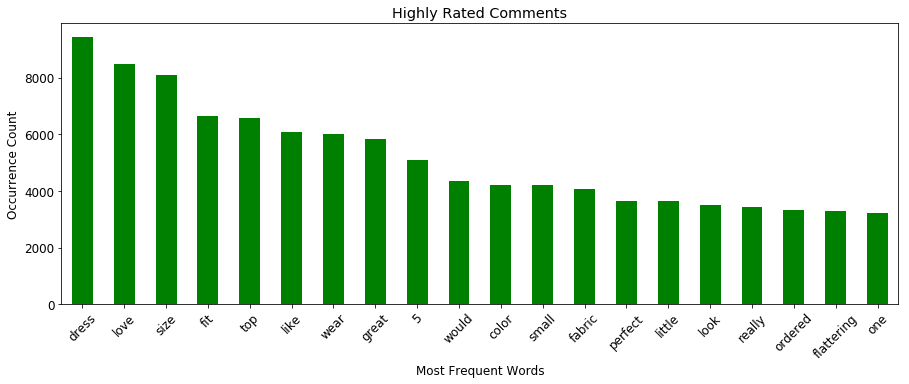

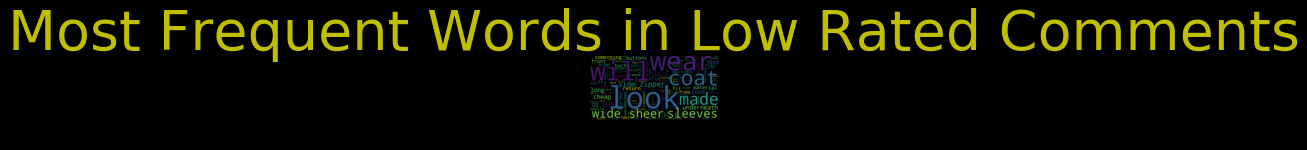

In [34]:
# Highly Raited
title ="Highly Rated Comments"
temp = df['Review Text'][df.Rating.astype(int) >= 3]

# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite"])

# Cloud
cloud(text= temp.values, title=title,stopwords= new_stop)

# Bar Chart
wordfreq(preprocessing(temp),20).plot.bar(rot=45, legend=False,figsize=(15,5), color='g',
                          title= title)
plt.ylabel("Occurrence Count")
plt.xlabel("Most Frequent Words")
plt.show()

# Low Raited
title ="Most Frequent Words in Low Rated Comments"
temp = df['Review Text'][df.Rating.astype(int) < 3]

# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite", "skirt","shirt"])

# Cloud
cloud(temp.values, title= title, stopwords = new_stop)

**Taking a Different Lense: WordClouds by Department Name** <br>

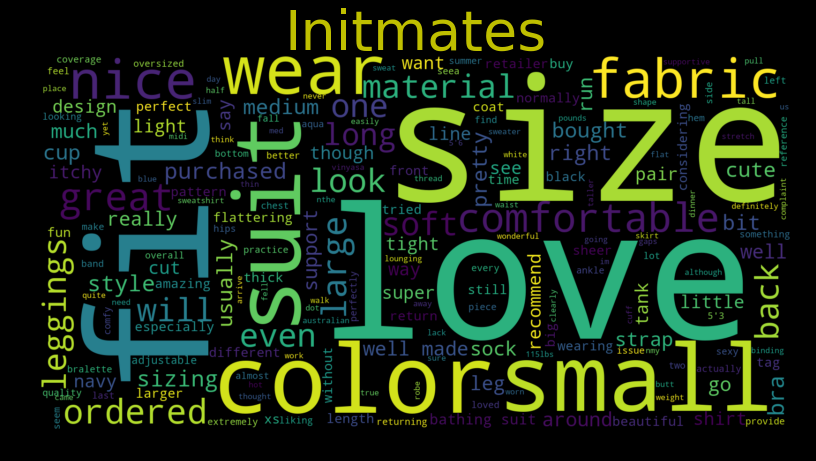

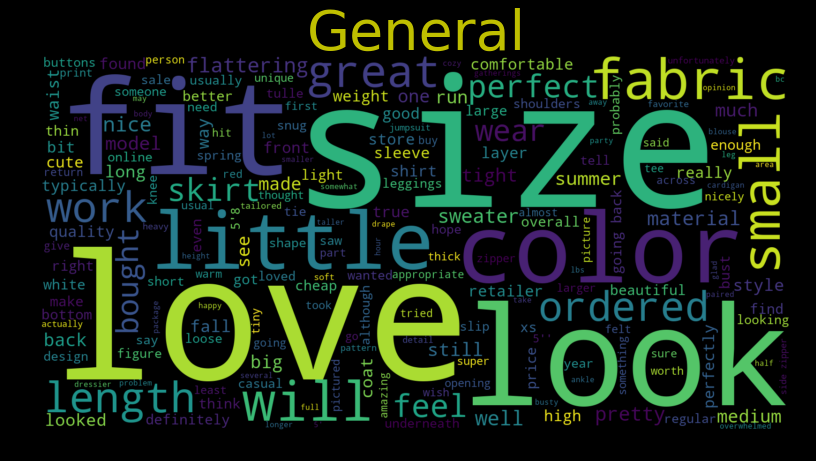

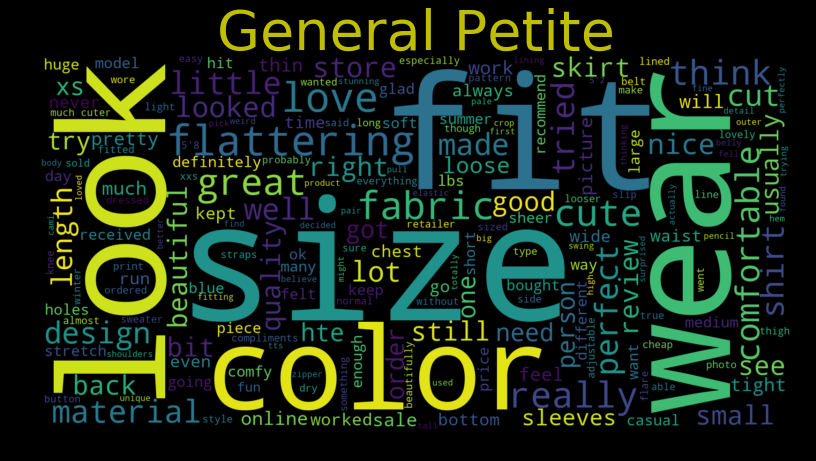

In [35]:
department_set = df["Department Name"][df["Department Name"].notnull()].unique()
division_set = df["Division Name"][df["Division Name"].notnull()].unique()
def cloud_by_category(data, category, subclass):
    """
    Function to create a wordcloud by class and subclass
    Category signifies the column variable
    Subclass refers to the specific value within the categorical variable
    """
    new_stop = set(STOPWORDS)
    new_stop.update([x.lower() for x in list(data["Class Name"][data["Class Name"].notnull()].unique())]
                   + [x.lower() for x in list(data["Department Name"][data["Department Name"].notnull()].unique())]
                   + ["dress", "petite", "jacket","top"])

    # Cloud
    cloud(text= data["Review Text"][data[category]== subclass],
          title="{}".format(subclass),
          stopwords= new_stop,
          size = (10,6))
    
# Plot
cloud_by_category(df, "Division Name", division_set[0])
cloud_by_category(df, "Division Name", division_set[1])
cloud_by_category(df, "Division Name", division_set[2])


## N Grams by Recommended Feature


In [36]:
from nltk.util import ngrams
from collections import Counter
def get_ngrams(text, n):
    n_grams = ngrams((text), n)
    return [ ' '.join(grams) for grams in n_grams]

def gramfreq(text,n,num):
    # Extracting bigrams
    result = get_ngrams(text,n)
    # Counting bigrams
    result_count = Counter(result)
    # Converting to the result to a data frame
    df = pd.DataFrame.from_dict(result_count, orient='index')
    df = df.rename(columns={'index':'words', 0:'frequency'}) # Renaming index column name
    return df.sort_values(["frequency"],ascending=[0])[:num]

def gram_table(data, gram, length):
    out = pd.DataFrame(index=None)
    for i in gram:
        table = pd.DataFrame(gramfreq(preprocessing(data),i,length).reset_index())
        table.columns = ["{}-Gram".format(i),"Occurrence"]
        out = pd.concat([out, table], axis=1)
    return out

In [37]:
print("Non-Recommended Items")
gram_table(data= df['Review Text'][df["Recommended IND"].astype(int) == 0], gram=[1,2,3,4,5], length=30)

Non-Recommended Items


,1-Gram,Occurrence,2-Gram,Occurrence,3-Gram,Occurrence,4-Gram,Occurrence,5-Gram,Occurrence
0,dress,1976,wanted love,243,really wanted love,70,really wanted love dress,15,reference 5 7 125 lb,3
1,like,1780,going back,215,wanted love dress,65,looked like maternity top,10,going back wanted love dress,3
2,top,1572,looked like,187,really wanted like,40,really wanted like dress,9,reference measurements 38 30 40,3
3,would,1348,looks like,153,made look like,29,really wanted like top,9,photos reference measurements 38 30,3
4,fit,1327,really wanted,151,wanted love top,28,5 4 120 lbs,8,medium photos reference measurements 38,3
5,fabric,1245,made look,135,fit true size,28,really wanted love top,7,wearing medium photos reference measurements,3
6,size,1209,look like,126,ordered usual size,25,5 7 140 lbs,6,back really wanted like dress,3
7,back,1039,5 4,113,way much fabric,25,measurements 38 30 40,6,arm holes also cut low,3
8,look,965,felt like,109,sadly going back,24,going back really wanted,6,wanted top work looks cute,2
9,love,928,true size,104,like maternity top,23,would look better someone,5,sides much shorter front back,2


In [38]:
print("Recommended Items")
gram_table(data= df['Review Text'][df["Recommended IND"].astype(int) == 1], gram=[1,2,3,4,5], length=30)

Recommended Items


,1-Gram,Occurrence,2-Gram,Occurrence,3-Gram,Occurrence,4-Gram,Occurrence,5-Gram,Occurrence
0,dress,8591,true size,1243,fits true size,264,compliments every time wear,46,34b 26 waist 36 hips,27
1,love,8017,love dress,657,fit true size,192,26 waist 36 hips,32,get compliments every time wear,21
2,size,7561,5 4,622,received many compliments,163,34b 26 waist 36,28,5 2 currently 33 25,17
3,fit,5995,usually wear,588,runs true size,143,looks great skinny jeans,25,115 lbs 30 dd 26,15
4,top,5846,looks great,574,love love love,138,get compliments every time,23,2 currently 33 25 37,13
5,wear,5678,fit perfectly,553,usually wear size,107,love love love dress,22,115 lbs 30dd 26 5,13
6,great,5584,well made,531,every time wear,81,115 lbs 30 dd,22,lbs 30 dd 26 5,13
7,like,5368,love top,524,ordered usual size,79,usually wear size 4,21,30 dd 26 5 waist,12
8,5,4678,5 3,488,small fit perfectly,72,5 4 120 lbs,20,5 1 5 115 lbs,12
9,color,3887,fits perfectly,480,got many compliments,70,5 5 135lbs 34c,18,lbs 30dd 26 5 waist,12


#### Thats all for this kernel
**Thank You<br>
Pawan Kumar Jain**